## Train a VAE

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'transcriptomics': 3696, 'velocity': 3696}, 'annotation': {'paired': 3696}, 'img': {'img': 0}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 3696}}
cur shape: transcriptomics: (2586, 500)
cur shape: velocity: (2586, 500)
cur shape: transcriptomics: (740, 500)
cur shape: velocity: (740, 500)
cur shape: transcriptomics: (370, 500)
cur shape: velocity: (370, 500)
Epoch 5/100 - Train Loss: 2155577.4727
Sub-losses: recon_loss: 2155561.3164, var_loss: 159887.1906, anneal_factor: 0.0001, effective_beta_factor: 0.0001
Epoch 5/100 - Valid Loss: 284552.8672
Sub-losses: recon_loss: 284550.2734, var_loss: 25680.9707, anneal_factor: 0.0001, effective_beta_factor: 0.0001
Epoch 10/100 - Train Loss: 2028036.0098
Sub-losses: recon_loss: 2027953.4746, var_loss: 300602.7400, anneal_factor: 0.0003, effective_beta_factor: 0.0003
Epoch 1

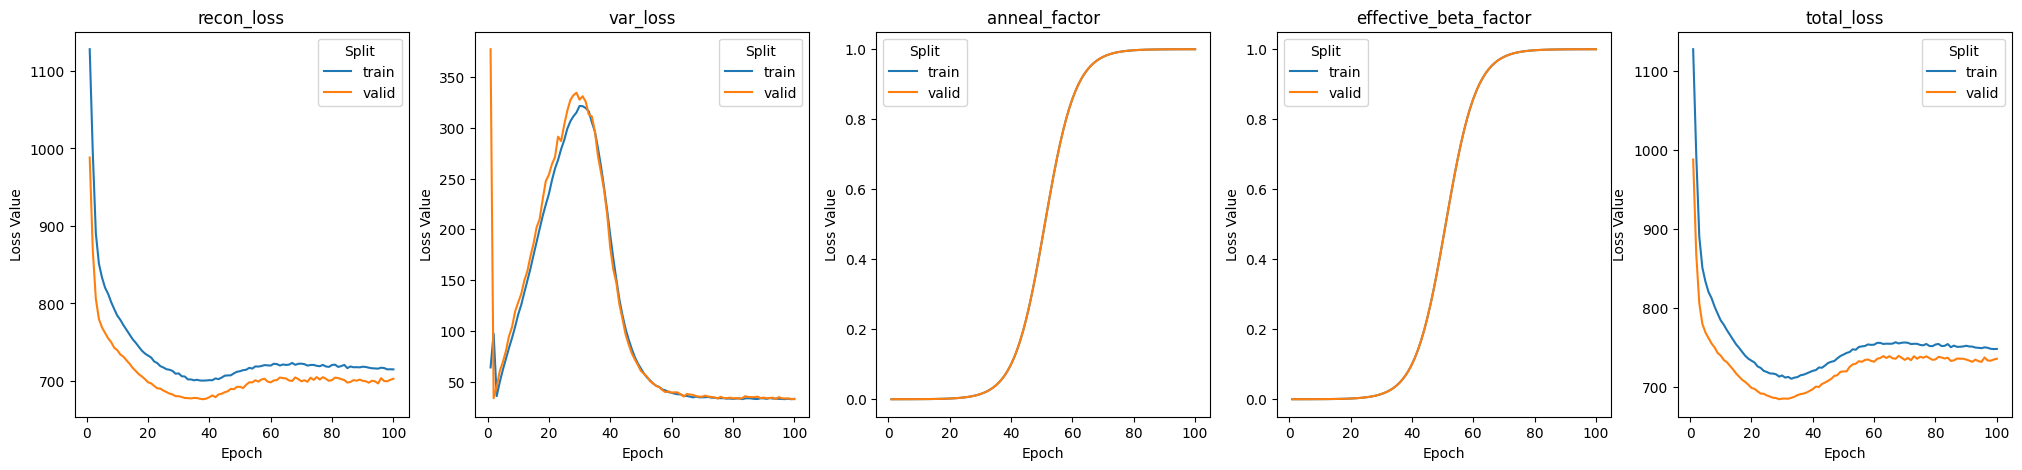

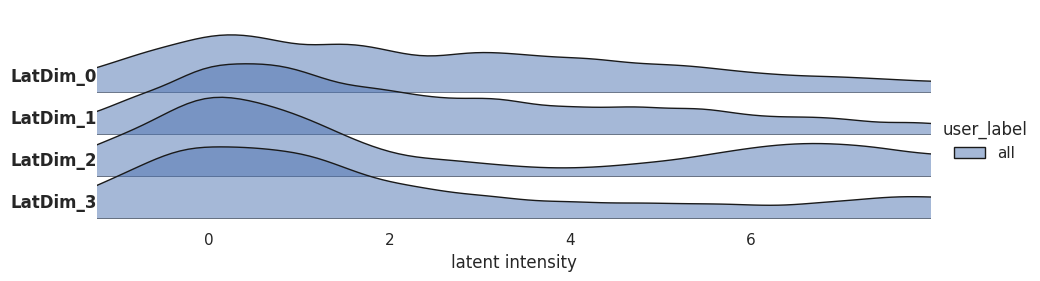

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


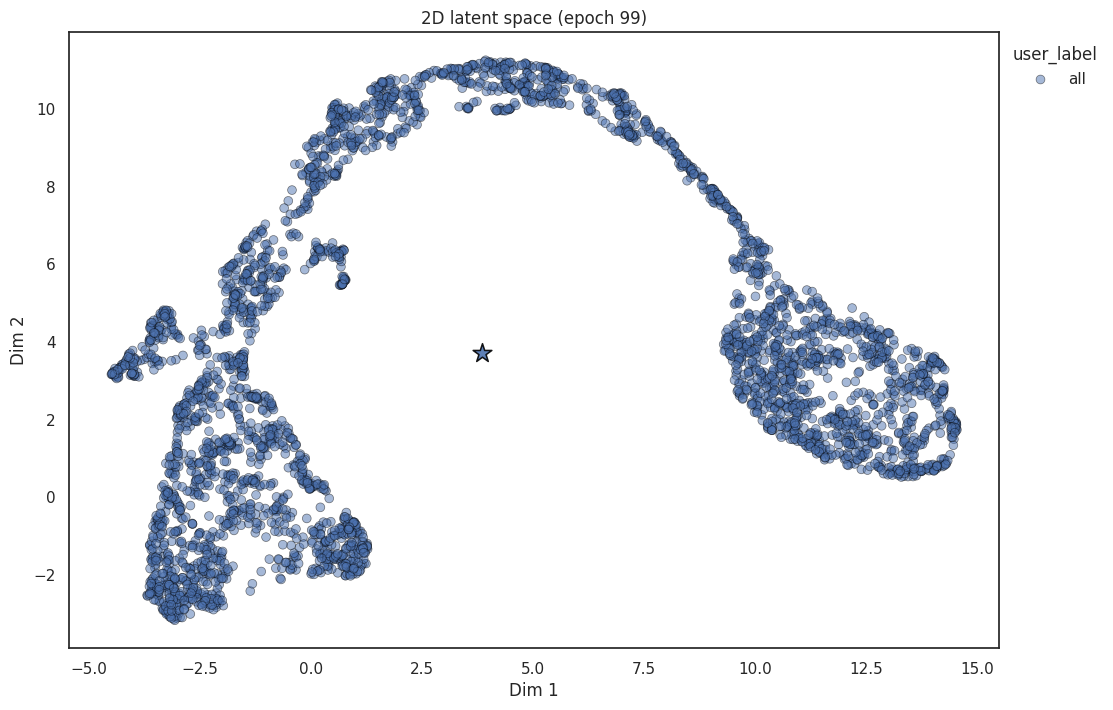

In [ ]:
from autoencodix.utils.default_config import DefaultConfig
import autoencodix as acx
import pandas as pd

from autoencodix.utils.default_config import DataCase
from autoencodix.data.datapackage import DataPackage

df_rna = pd.read_parquet("./input_data_test/scvelo_01_pancreas_adata_ncbi_formatted.parquet")
df_velo = pd.read_parquet("./input_data_test/scvelo_01_pancreas_adata_ncbi_velocity_formatted.parquet")
df_anno = pd.read_parquet("./input_data_test/scvelo_01_pancreas_adata_ncbi_clinical_formatted.parquet")

data_package = DataPackage()
data_package.multi_bulk = {"transcriptomics": df_rna, "velocity": df_velo}
data_package.annotation = {
	"paired": df_anno.copy(),
}

my_cfg = DefaultConfig(
	data_case=DataCase.MULTI_BULK,
	loss_reduction="sum",
	k_filter=1000,
	latent_dim=4,
	scaling="STANDARD",
	filtering="VAR",
	epochs=100,
	learning_rate=0.0005,
	batch_size = 128,
	beta = 1,
	drop_p =0.25,
	global_seed=42,
	checkpoint_interval=5,
	n_layers=1
	)


varix = acx.Varix(data=data_package, config=my_cfg)
result = varix.run()


## Show 1-3 most relevant plots like loss, latent space, ... 
varix.show_result()



## Getting visualization with Annotation data/param and for specific epoch or split

In [2]:
result.datasets.train.metadata['paired'].columns

Index(['clusters_coarse', 'clusters', 'S_score', 'G2M_score',
       'initial_size_unspliced', 'initial_size_spliced', 'initial_size',
       'n_counts', 'velocity_self_transition', 'n_genes'],
      dtype='object')

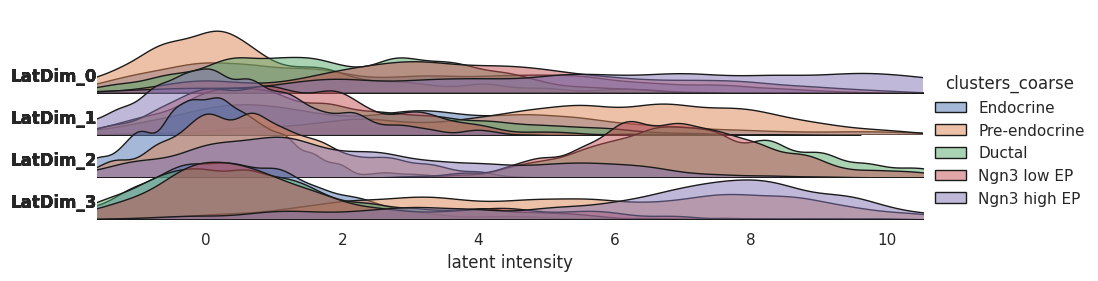

In [3]:
# sample_anno= pd.read_parquet('../data/ANNO_data.parquet')

# label_list_all = list(sample_anno.iloc[
# 	np.concatenate((
# 		custom_train_indices,
# 		custom_valid_indices,
# 		custom_test_indices
# 	), axis=0),:].loc[:,
# 	'clusters_coarse'])

param_list = ['clusters_coarse']

varix._visualizer.show_latent_space(result=varix.result, plot_type="Ridgeline", split='all', param=param_list)

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


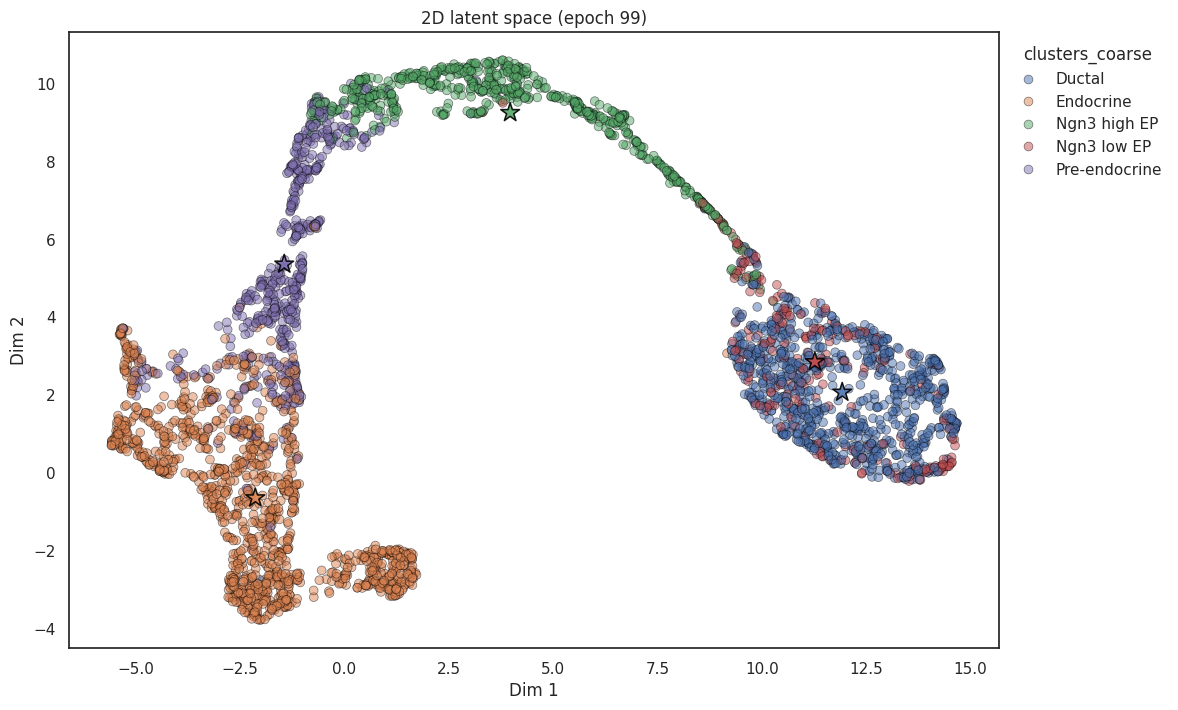

In [4]:
varix._visualizer.show_latent_space(result=varix.result, plot_type="2D-scatter", split='all', param=param_list)

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


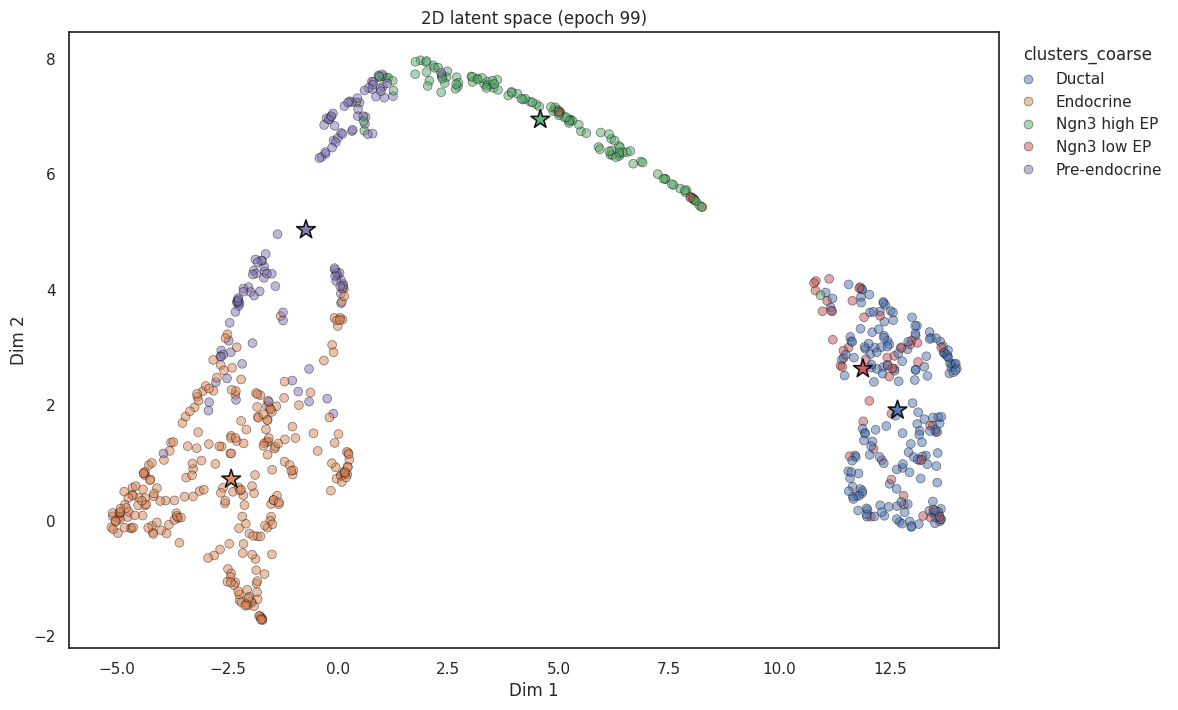

In [5]:
varix._visualizer.show_latent_space(result=varix.result, plot_type="2D-scatter", split='test', param=param_list)

## Perform Clustering and plot cluster labels

In [6]:
## Do clustering with KMeans from sklearn
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42) ## 5 clusters as in clusters_coarse

In [7]:
# combine latent space for train, valid and test
latent_df = pd.concat([
	result.get_latent_df(split='train', epoch=-1),
	result.get_latent_df(split='valid', epoch=-1),
	result.get_latent_df(split='test', epoch=-1)
])
kmeans = kmeans.fit(latent_df)

# kmeans.labels_

## Store labels in pd.Series with index from latent_df
labels_series = pd.Series(
	["Cluster_"+str(L) for L in kmeans.labels_],
	index=latent_df.index,
	name='KMeans')

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


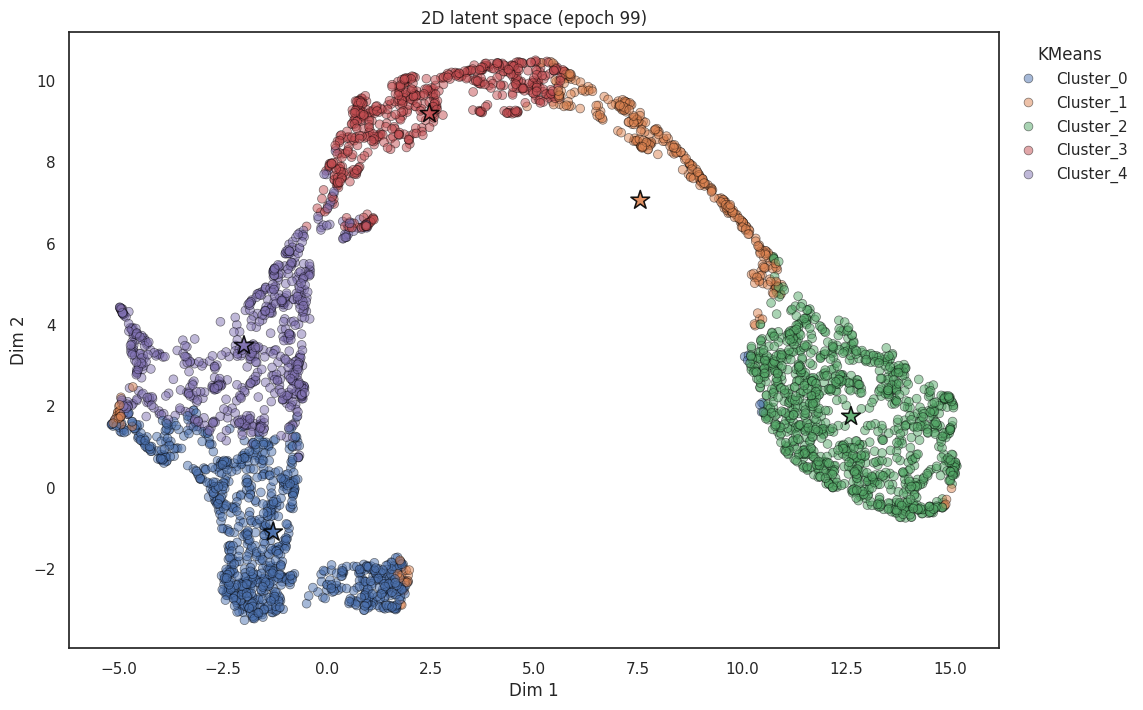

In [9]:
varix._visualizer.show_latent_space(result=varix.result, plot_type="2D-scatter", split='all', labels=labels_series)

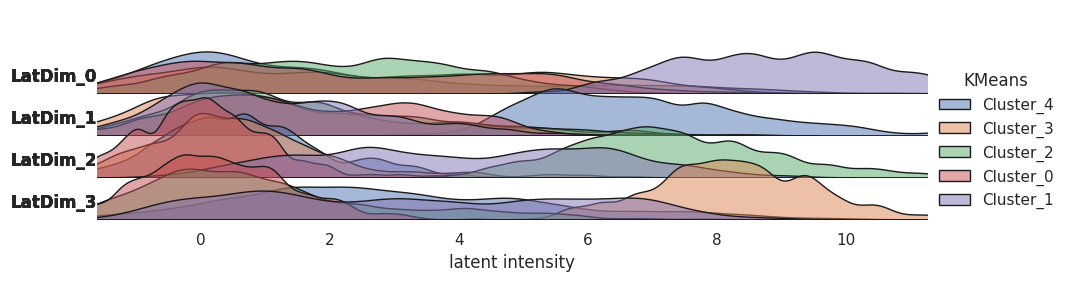

In [10]:
varix._visualizer.show_latent_space(result=varix.result, plot_type="Ridgeline", split='all', labels=labels_series)

## Save Plots

In [11]:
varix._visualizer.save_plots(path='./my_varix_plots/', which='all', format='png')

## Model weight visualization development

In [12]:
result.model

VarixArchitecture(
  (_encoder): Sequential(
    (0): Linear(in_features=1000, out_features=250, bias=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
  )
  (_mu): Linear(in_features=250, out_features=4, bias=True)
  (_logvar): Linear(in_features=250, out_features=4, bias=True)
  (_decoder): Sequential(
    (0): Linear(in_features=4, out_features=250, bias=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=1000, bias=True)
  )
)

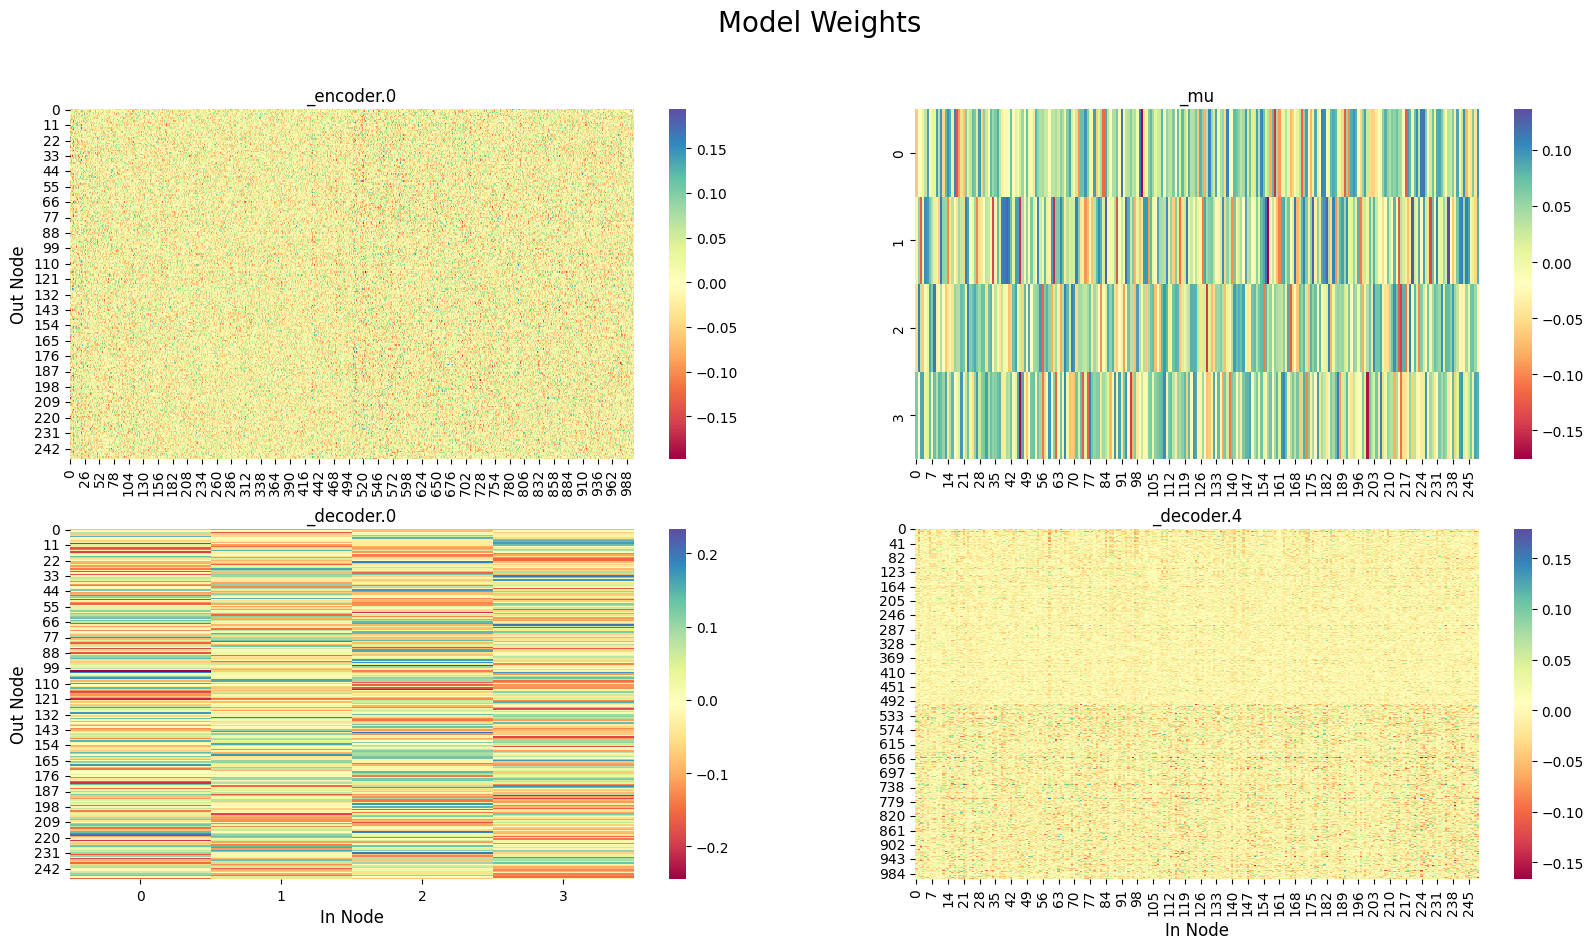

In [13]:
varix._visualizer.show_weights()

## Make Animation of latent space evolving over epochs?

In [ ]:
# TODO
# import matplotlib.animation as animation

# # Function to update the ridgeline plot for each epoch
# def update(epoch):
# 	# plt.clf()
# 	g = show_latent_space(type="Ridgeline", split='all', label_list=list(sample_anno.loc[:,'clusters_coarse']), param='clusters_coarse', epoch=epoch)
# 	# plt.title(f'Epoch {epoch}')
# 	plt.close()
# 	return g

# # Create the figure
# fig = plt.figure(figsize=(12, 8))

# # Create the animation
# # ani = animation.FuncAnimation(fig, update, frames=range(varix.config.epochs), repeat=False)
# ani = animation.FuncAnimation(fig, update, frames=range(10), repeat=False)


# # Save the animation as a GIF
# ani.save('ridgeline_animation.gif', writer='imagemagick')

# # Display the animation
# plt.show()